In [2]:
import torch
import cv2
import os
import pandas as pd
import seaborn as sns
from PIL import Image, ImageGrab
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn import CrossEntropyLoss, Module, Linear
from torch.optim import Adam
from torch.nn.functional import relu, softmax, log_softmax
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score ,precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk

FUNCTION TO CONVERT AN ARRAY OF NUMBER INTO AN IMAGE IN A FOLDER

In [4]:
def SaveImages(path):
    df = pd.read_csv(path)

    output_dir = 'Dataset_images'
    os.makedirs(output_dir, exist_ok=True)

    image_size = (28,28)
    label = df.iloc[:, 0]
    df = df.drop(df.columns[0], axis=1)
    df = 255 - df
    for index, row in df.iterrows():
        pixels = row.values.astype(np.uint8)
        image_array = pixels.reshape(image_size)
        image = Image.fromarray(image_array)
        image_filename = f'{output_dir}/{label[index]}_{index}.png'
        image.save(image_filename)

In [ ]:
SaveImages("A_Z Handwritten Data.csv")

In [3]:
number_to_letter = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y',
    25: 'Z'
}


UPLOAD THE IMAGES AND THE CORRESPONDING LABEL

In [7]:
def LoadData(path, separator = '_'):
    classes = os.listdir(path)
    images = []
    labels = []

    for img in classes:
        images.append(cv2.imread(f"{path}/{img}", cv2.IMREAD_GRAYSCALE))
        labels.append(int(img.split(separator)[0]))      #da sistemare il primo carattere: esempio 14 prende solo 1

    return images, labels

In [4]:
trainImage, trainLabels = LoadData("Dataset_images")

PRINT COME LETTERS OF THE FIRST DATASET

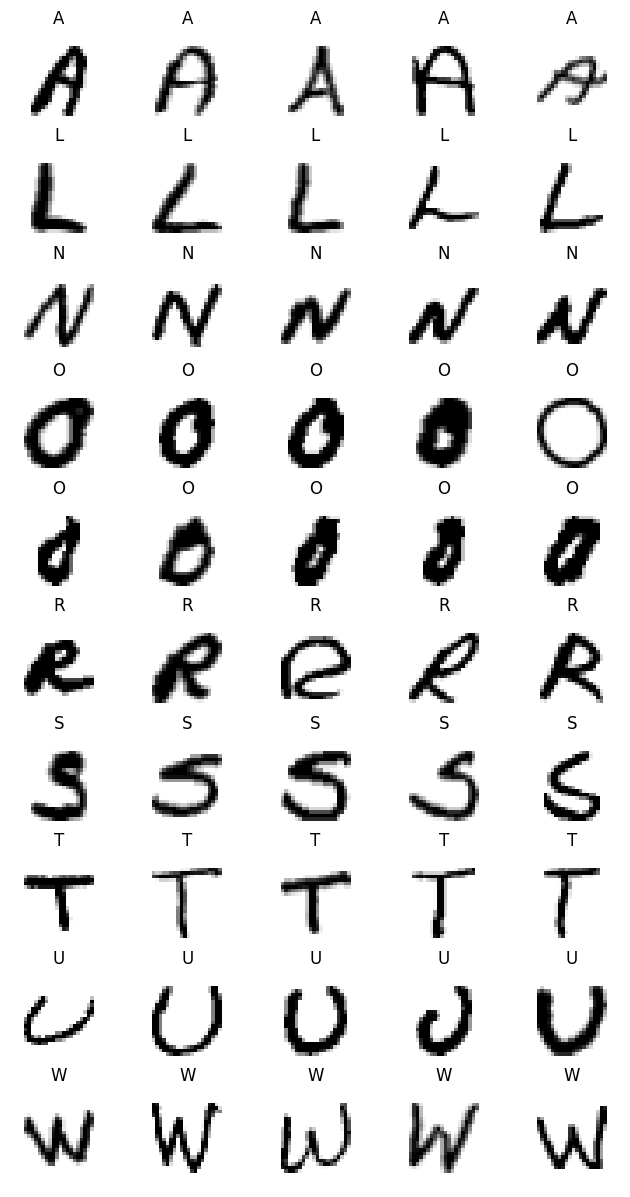

In [22]:

imgToDisplay = [trainImage[i:i+5] for i in range(0, len(trainImage), 30000)]
labelsToDisplay = [trainLabels[i:i+5] for i in range(0, len(trainLabels), 30000)]
fig, ax = plt.subplots(10, 5, figsize=(8, 15))

for i in range(10):
    for j in range(5):
        ax[i,j].imshow(imgToDisplay[i][j], cmap="gray")
        ax[i,j].axis("off")
        ax[i,j].set_title(number_to_letter[labelsToDisplay[i][j].item()])

CONVERT TO TENSOR AND SPLIT THE DATA

In [5]:
trainImage = torch.tensor(np.array(trainImage), dtype=torch.float)
trainLabels = torch.tensor(np.array(trainLabels), dtype=torch.long)

In [6]:
train_X, val_X, train_y, val_y = train_test_split(trainImage, trainLabels, shuffle=True, stratify=trainLabels, random_state=123)

NEURAL NETWORK

In [4]:
class ImprovedCNN(Module):
    def __init__(self):
        super().__init__()
        
        self.CNN1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.CNN2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Dropout = nn.Dropout(0.5)
        self.BatchNorm1 = nn.BatchNorm2d(32)
        self.BatchNorm2 = nn.BatchNorm2d(64)
        #self.hiddenLayer1 = Linear(64, 128)
        self.hiddenLayer1 = Linear(64 * 7 * 7, 128)
        self.outputLayer = Linear(128, 26)

    def forward(self, data):
        x = self.CNN1(data)
        x = self.BatchNorm1(x)
        x = relu(x)
        x = self.MaxPool(x)
        
        x = self.CNN2(x)
        x = self.BatchNorm2(x)
        x = relu(x)
        x = self.MaxPool(x)
        
        x = x.view(x.shape[0], -1)  # Flatten
        x = self.hiddenLayer1(x)
        x = relu(x)
        x = self.Dropout(x)
        
        x = self.outputLayer(x)
        return log_softmax(x, dim=1)




IMPORT THE DATASET

In [5]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]


FIRST TRAINING

In [ ]:

BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 5

CharacterTrain = CharacterDataset(train_X, train_y, transform = transforms)
trainDataLoader = DataLoader(CharacterTrain, batch_size=BATCH_SIZE, shuffle=True)

device = "cpu" if not torch.cuda.is_available() else "cuda:1"

model = ImprovedCNN()
model = model.to(device)

optim = Adam(model.parameters(), lr=LEARNING_RATE)

loss_func = CrossEntropyLoss()

totalBatches = len(trainDataLoader)
history = {"Loss": [], "Val Loss": [],"Accuracy": [], "Val Accuracy": []}
pbar = tqdm(range(EPOCHS))
for e in pbar:
    running_loss = 0
    running_acc = 0
    
    for imgBatch, labelBatch in trainDataLoader:
        # print(imgBatch)
        # print(labelBatch)
        optim.zero_grad()
        imgBatch = imgBatch.reshape(-1,1,28,28)

        imgBatch, labelBatch = imgBatch.to(device), labelBatch.to(device)
        
        out = model.forward(imgBatch)
        loss = loss_func(out, labelBatch)
        loss.backward()
        optim.step()
        running_loss += loss.item()
        predictedLabels = torch.argmax(out, 1)
        running_acc += (predictedLabels == labelBatch).sum()/len(labelBatch)
    
    val_X = val_X.view(-1,1, 28,28)
    out = model.forward(val_X)
    val_loss = loss_func(out , val_y).item()
    predictedLabels = out.argmax(axis=1)
    val_acc = (predictedLabels == val_y).sum()/len(val_y)

    history["Loss"].append(running_loss/totalBatches)
    print('loss')
    print(running_loss/totalBatches)
    history["Accuracy"].append(running_acc/totalBatches)
    print('accuracy')
    print(running_acc/totalBatches)
    history["Val Loss"].append(val_loss)
    history["Val Accuracy"].append(val_acc)

    pbar.set_postfix_str(f"Loss: { history['Loss'][-1]:.4f}, Accuracy: {history['Accuracy'][-1]:.4f}, Val Loss: {history['Val Loss'][-1]:.4f}, Val Accuracy: {history['Val Accuracy'][-1]:.4f}")
    

LOSS AND VALIDATION LOSS

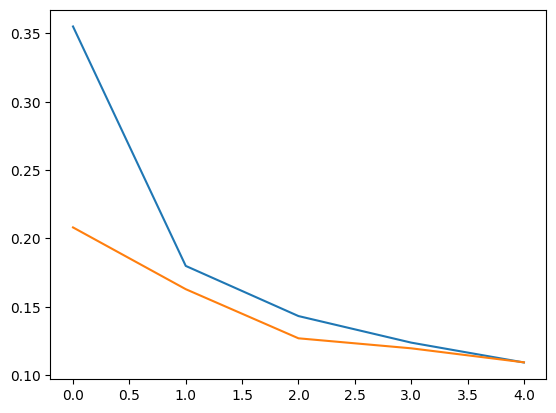

In [80]:
plt.plot(range(EPOCHS),history["Loss"])
plt.plot(range(EPOCHS), history["Val Loss"])
plt.show()

ACCURACY AND VALIDATION ACCURACY

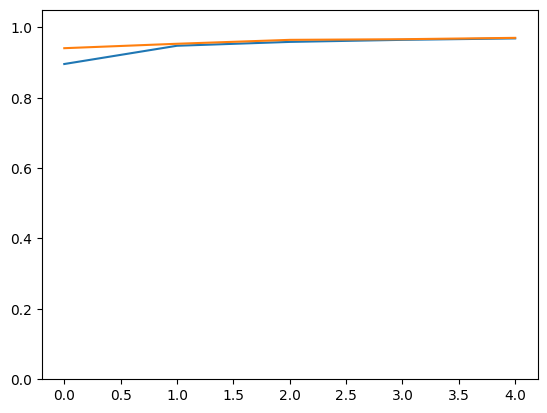

In [81]:
fig, ax = plt.subplots()
ax.plot(range(EPOCHS),history["Accuracy"])
ax.plot(range(EPOCHS), history["Val Accuracy"])
ax.set_ylim([0,1.05])
plt.show()

SOME TRIES TO FIND THE BEST WEIGHTS FOR THE NEURAL NETWORK

In [368]:
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optim.state_dict(),
},'modello.pth')

In [13]:
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optim.state_dict(),
},'model_fine_tuned.pth')

In [82]:
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optim.state_dict(),
},'model_5_EPOCHS.pth')

ACCURACY, PRECISION, RECALL AND CONFUSION MATRIX FOR THE FIRST TRAIN

Accuracy: 98.7778%
precision
0.9803449921542182
recall
0.9851654046251931


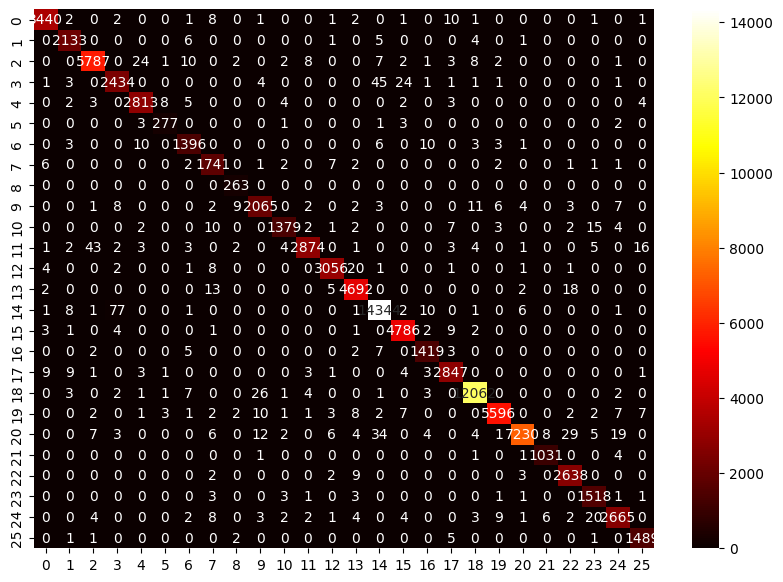

In [29]:
model = ImprovedCNN()
optimizer = Adam(model.parameters())

# Caricamento degli stati
checkpoint = torch.load('model_5_EPOCHS.pth')
#print("Stato del modello prima del caricamento:", model.state_dict())
model.load_state_dict(checkpoint['model_state_dict'])
#print("Stato del modello dopo il caricamento:", model.state_dict())

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Impostare il modello in modalità eval se necessario
val_X = val_X.reshape(-1,1, 28,28)
model.eval()
out = model.forward(val_X)
predictedLabels = torch.argmax(out, axis=1)

print(f"Accuracy: {accuracy_score(predictedLabels, val_y)*100:.4f}%")

print('precision')
print(precision_score(predictedLabels, val_y , average = 'macro'))

print('recall')
print(recall_score(predictedLabels, val_y, average='macro'))

cm = confusion_matrix(predictedLabels, val_y)

plt.figure(figsize = (10,7))
sns.heatmap(cm, cmap="hot", annot=True, fmt="d")
plt.show()

RESHAPE AND MODIFY MY OWN DATASET

In [ ]:
def process_images(input_folder, output_folder, target_size=(28, 28), min_color_level=100):
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        try:
            # Carica l'immagine utilizzando PIL
            image_path = os.path.join(input_folder, filename)
            img = Image.open(image_path)
            
            # Ridimensiona l'immagine
            img = img.resize(target_size)
            
            # Applica un filtro per eliminare colori sotto il livello minimo
            img = img.point(lambda p: p > min_color_level and p)
            
            # Converte l'immagine in formato OpenCV per salvare
            img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
            # Salva l'immagine nel percorso di output
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, img_cv)
            
            print(f"Processed: {filename}")
        
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")


In [22]:
def threshold(gray_image, threshold_value = 128):
    _ ,binary_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
    return binary_image

In [4]:
def binarization(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        try:
            # Carica l'immagine utilizzando PIL
            image_path = os.path.join(input_folder, filename)
            img = Image.open(image_path).convert('RGB')
            img_np = np.array(img)
            gray_image = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            
            
            
            binary_image = threshold(gray_image)
            # Applica un filtro per eliminare colori sotto il livello minimo
            #_, binary_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
            
            # Salva l'immagine nel percorso di output
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, binary_image)
            
            print(f"Processed: {filename}")
        
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")




In [ ]:
process_images("My_dataset - Copia", "nuova_cartella_2")

In [ ]:
binarization('nuova_cartella_2' , 'nuova_cartella_3')

In [8]:
trainImage2, trainLabels2 = LoadData("nuova_cartella_3" , '(')

PRINT SOME LETTERS FROM MY DATASET

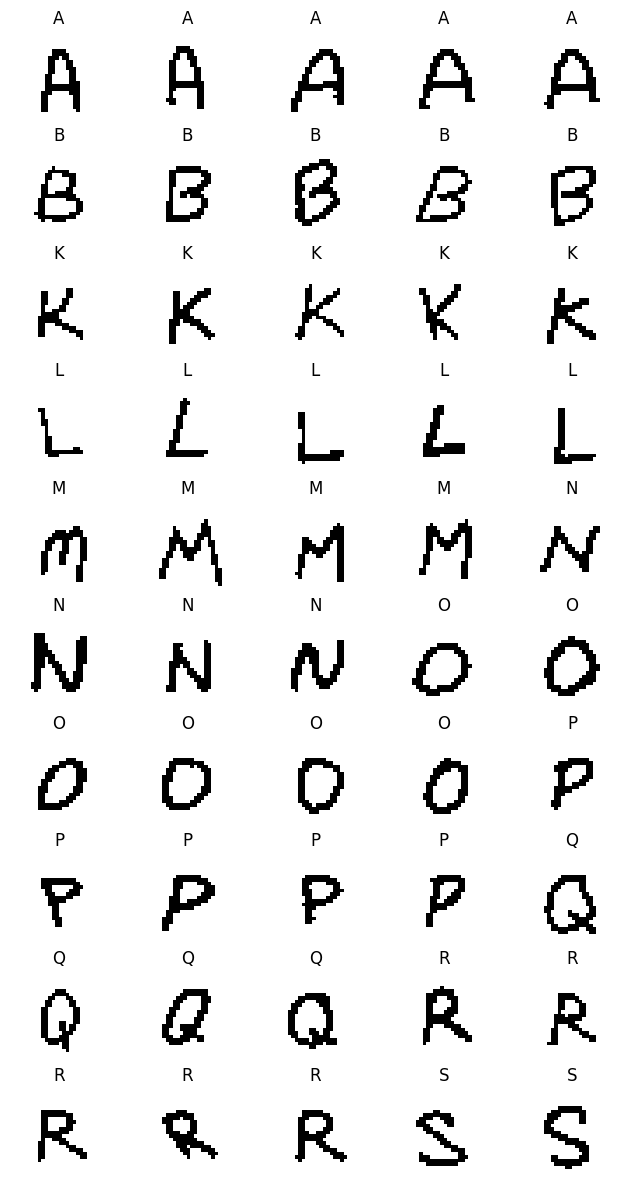

In [37]:
imgToDisplay = [trainImage2[i:i+5] for i in range(0, len(trainImage2), 10)]
labelsToDisplay = [trainLabels2[i:i+5] for i in range(0, len(trainLabels2), 10)]
fig, ax = plt.subplots(10, 5, figsize=(8, 15))

for i in range(10):
    for j in range(5):
        ax[i,j].imshow(imgToDisplay[i][j], cmap="gray")
        ax[i,j].axis("off")
        ax[i,j].set_title(number_to_letter[labelsToDisplay[i][j]])

CONVERT TO TENSOR AND SPLIT

In [9]:
trainImg2 = torch.tensor(np.array(trainImage2), dtype=torch.float)
trainLabels2 = torch.tensor(np.array(trainLabels2), dtype=torch.long)

In [10]:
train_X2, val_X2, train_y2, val_y2 = train_test_split(trainImg2, trainLabels2, shuffle=True, stratify=trainLabels2, random_state=90)

UPLOAD THE WEIGHTS OF THE FIRST TRAINING

In [11]:
model = ImprovedCNN()
optim = Adam(model.parameters())

# Caricamento degli stati
checkpoint = torch.load('model_5_EPOCHS.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])



SECOND TRAINING

In [12]:
BATCH_SIZE = 16
LEARNING_RATE = 0.00001
EPOCHS = 30

CharacterTrain = CharacterDataset(train_X2, train_y2, transform = transforms)
trainDataLoader = DataLoader(CharacterTrain, batch_size=BATCH_SIZE, shuffle=True)

device = "cpu" if not torch.cuda.is_available() else "cuda:1"

loss_func = CrossEntropyLoss()

totalBatches = len(trainDataLoader)
history = {"Loss": [], "Val Loss": [],"Accuracy": [], "Val Accuracy": []}
pbar = tqdm(range(EPOCHS))
for e in pbar:
    running_loss = 0
    running_acc = 0
    
    for imgBatch, labelBatch in trainDataLoader:
        # print(imgBatch)
        # print(labelBatch)
        optim.zero_grad()
        imgBatch = imgBatch.reshape(-1,1,28,28)

        imgBatch, labelBatch = imgBatch.to(device), labelBatch.to(device)
        
        out = model.forward(imgBatch)
        loss = loss_func(out, labelBatch)
        loss.backward()
        optim.step()
        running_loss += loss.item()
        predictedLabels = torch.argmax(out, 1)
        running_acc += (predictedLabels == labelBatch).sum()/len(labelBatch)
    
    val_X2 = val_X2.view(-1,1, 28,28)
    out = model.forward(val_X2)
    val_loss = loss_func(out , val_y2).item()
    predictedLabels = out.argmax(axis=1)
    val_acc = (predictedLabels == val_y2).sum()/len(val_y2)

    history["Loss"].append(running_loss/totalBatches)
    print('loss')
    print(running_loss/totalBatches)
    history["Accuracy"].append(running_acc/totalBatches)
    print('accuracy')
    print(running_acc/totalBatches)
    history["Val Loss"].append(val_loss)
    history["Val Accuracy"].append(val_acc)

    pbar.set_postfix_str(f"Loss: { history['Loss'][-1]:.4f}, Accuracy: {history['Accuracy'][-1]:.4f}, Val Loss: {history['Val Loss'][-1]:.4f}, Val Accuracy: {history['Val Accuracy'][-1]:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

loss
0.4784028008580208
accuracy
tensor(0.8771)
loss
0.28971956856548786
accuracy
tensor(0.8906)
loss
0.11283692760480335
accuracy
tensor(0.9792)
loss
0.12619242343741158
accuracy
tensor(0.9635)
loss
0.10461656951035063
accuracy
tensor(0.9635)
loss
0.14335740311071277
accuracy
tensor(0.9500)
loss
0.10634227003902197
accuracy
tensor(0.9656)
loss
0.08957820866877834
accuracy
tensor(0.9604)
loss
0.10320559004321694
accuracy
tensor(0.9635)
loss
0.1420467758240799
accuracy
tensor(0.9552)
loss
0.0967521004883262
accuracy
tensor(0.9552)
loss
0.04549985800986178
accuracy
tensor(0.9865)
loss
0.11154908857618769
accuracy
tensor(0.9552)
loss
0.055035214597107064
accuracy
tensor(0.9792)
loss
0.13273869228820936
accuracy
tensor(0.9583)
loss
0.08698338856144498
accuracy
tensor(0.9708)
loss
0.06717219209046259
accuracy
tensor(0.9792)
loss
0.09819991430291945
accuracy
tensor(0.9740)
loss
0.04646109005625476
accuracy
tensor(0.9896)
loss
0.024071617660714157
accuracy
tensor(0.9948)
loss
0.08013189900945

LOSS AND VALIDATION LOSS

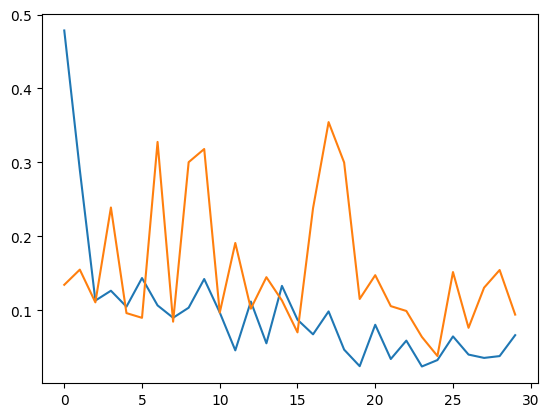

In [13]:
plt.plot(range(EPOCHS),history["Loss"])
plt.plot(range(EPOCHS), history["Val Loss"])
plt.show()

ACCURACY AND VALIDATION ACCURACY

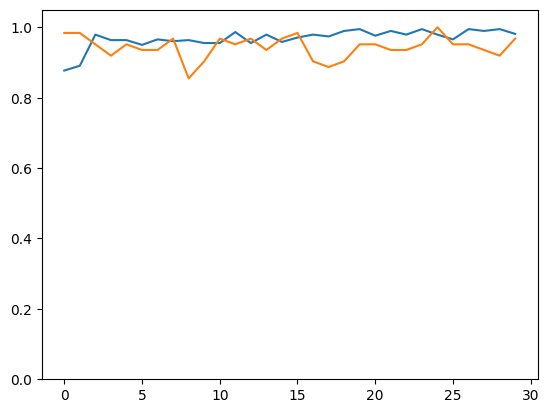

In [14]:
fig, ax = plt.subplots()
ax.plot(range(EPOCHS),history["Accuracy"])
ax.plot(range(EPOCHS), history["Val Accuracy"])
ax.set_ylim([0,1.05])
plt.show()

SAVE THE FINAL WEIGHTS

In [23]:
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optim.state_dict(),
},'model_complete.pth')

In [15]:
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optim.state_dict(),
},'model_complete_5_EPOCHS.pth')

ACCURACY, PRECISION, RECALL AND CONFUSION MATRIX FOR THE SECOND TRAINING

Accuracy: 98.3871%
precision
0.9871794871794871
recall
0.9871794871794872


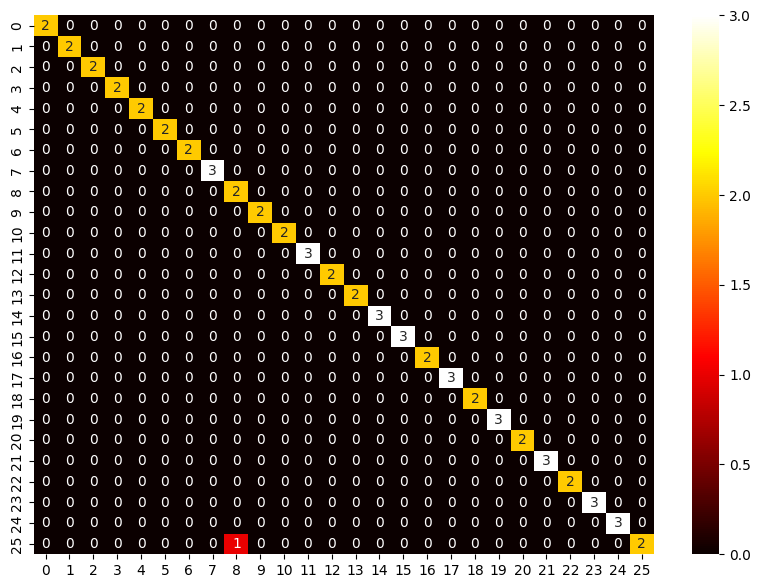

In [19]:
model = ImprovedCNN()
optimizer = Adam(model.parameters())

# Caricamento degli stati
checkpoint = torch.load('model_complete_5_epochs.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
val_X2 = val_X2.reshape(-1,1, 28,28)
with torch.no_grad():  # Disable gradient calculation
    output = model(val_X2)
    predicted_label = torch.argmax(output, axis=1)

print(f"Accuracy: {accuracy_score(predicted_label, val_y2)*100:.4f}%")


print('precision')
print(precision_score(predicted_label, val_y2 , average = 'macro'))

print('recall')
print(recall_score(predicted_label, val_y2, average='macro'))

cm = confusion_matrix(predicted_label, val_y2)

plt.figure(figsize = (10,7))
sns.heatmap(cm, cmap="hot", annot=True, fmt="d")
plt.show()

INTERFACE FOR THE REAL-TIME PREDICTION

In [20]:
class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.x = self.y = 0
        # Creating elements
        self.canvas = tk.Canvas(self, width=300, height=300, bg="white", cursor="cross")
        self.label = tk.Label(self, text="Thinking..", font=("Helvetica", 48))
        self.classify_btn = tk.Button(self, text="Recognise", command=self.classify_handwriting)
        self.button_clear = tk.Button(self, text="Clear", command=self.clear_all)
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky='w')
        self.label.grid(row=0, column=1, pady=2, padx=2)
        self.classify_btn.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        # Bindings
        self.canvas.bind("<B1-Motion>", self.draw_lines)
    
    def clear_all(self):
        self.canvas.delete("all")
    
    def classify_handwriting(self):
        # HWND = self.canvas.winfo_id()  # get the handle of the canvas
        # rect = self.canvas.winfo_rootx(), self.canvas.winfo_rooty(), self.canvas.winfo_rootx() + self.canvas.winfo_width(), self.canvas.winfo_rooty() + self.canvas.winfo_height()
        # im = ImageGrab.grab(rect)
        self.update_idletasks()  # Ensure the canvas is updated

        # Get the coordinates of the canvas
        x = self.canvas.winfo_rootx() + 45  # Adjust left padding
        y = self.canvas.winfo_rooty()   # Adjust top padding
        x1 = x + self.canvas.winfo_width() + 50  # Adjust right padding
        y1 = y + self.canvas.winfo_height() + 80  # Adjust bottom padding
        # Capture the canvas area
        im = ImageGrab.grab(bbox=(x, y, x1, y1))
        #im.show()
        # im = im.convert('L')
   
        #im = torch.tensor(np.array(im), dtype=torch.float)
        
        im = im.resize((28 , 28))
        im = im.convert('L')
        
        
        im = np.array(im)
        #im = im/255.0
        im = torch.tensor(np.array(im), dtype=torch.float)
        im = im.reshape(-1 , 28, 28)
        im = im.unsqueeze(0)# Add batch dimension
        
        print(f"Image size after transform: {im.size()}")
        
        # Forward pass through the model
        with torch.no_grad():
            out = model(im)
            digit = torch.argmax(out, axis=1).item()
        self.label.configure(text=str(number_to_letter[digit]))
    
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r = 8
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')



In [21]:
model = ImprovedCNN()
optimizer = Adam(model.parameters())

# Caricamento degli stati
checkpoint = torch.load('model_complete_5_EPOCHS.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Impostare il modello in modalità eval se necessario
model.eval()
app = App()
app.mainloop()

Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size after transform: torch.Size([1, 1, 28, 28])
Image size